<a href="https://colab.research.google.com/github/sophiakolak/LyrAIcs/blob/main/lyrAIcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LyrAIcs**

---



Some simple functions for visualizing audio signals + generating lyrics in different genres and moods using GPT-3. 


*How it Works:*
---


1. Upload an audio file 
2. Select a portion of the file (in seconds) you want to generate lyrics for 
3. Specify a mood, genre, sampling temperature, and an initial line to rhyme with, or go "random mode" and watch the chaos

That's it! The model is configured to generate 10 sample lyrics at a time (can be changed in the API call, but don't reccomend increasing). What you do next is up to you. The lyrics are designed to fit the audio signal you selected, but if you don't want to use audio at all, you can just manually specify the parameter "num_syllables" (I would reccomend 9-14).  

Or, if you want to go complete random mode, you can and let the model generate a lyric based only on your tone/genre/syllable spec. For this option, just check the "random mode" option (in the [Parameters](https://colab.research.google.com/drive/1e63PNY_CjogwGIEKr5OoXN244yPx-UZS#scrollTo=AeBl0EuRkmNf&line=14&uniqifier=1) cell).  


*How I used it:*
---

For the song I showed in class, I took the output text for each 15 second clip and turned it into speech using [uberduck.ai](https://uberduck.ai/). This site recently went viral on TikTok and you can make some pretty hilarious stuff with it, but it's not ideal if you're trying to make something serious. 

After I had the speech, I just matched it up to the corresponding time frames in Logic. I would've liked to do this all in the notebook but I ran out of time so...sorry!  

*Disclaimer:*
---
The model's output is unfiltered, so it may say something raunchy/offensive/poltiically incorrect, especially if you prompt it with certain types of phrases. 

Install Requirements

In [ ]:
!pip install openai
!pip install librosa
!pip install IPython
!pip install mir_eval

Load imports/API key (you can use mine until it runs out 🤷)

In [ ]:
import openai
import librosa
from IPython.display import Audio
import mir_eval.sonify
import numpy as np
import os
import numpy, scipy, matplotlib.pyplot as plt

In [ ]:
#@title Enter your openai API key
#@markdown I used to just have mine here, but "open"ai has eneded their free trial, so no more access 
#@markdown  (will eventually redo with a free API)

OPENAI_API_KEY = ''#@param {type:"string"}

openai.api_key = OPENAI_API_KEY

In [ ]:
#@title Load the audio file 
#@markdown Ensure you have uploaded your backing track it to the root directory.
#@markdown  Also, ignore the warning "PySoundFile failed..." if you are loading from a .mp3 file. 

path = 'audio.mp3'#@param {type:"string"}
assert os.path.exists(path), "The file does not exist."

y, sr = librosa.load(path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [ ]:
#@title Select audio section:
#@markdown Give the starting point and how long you want the clip to be (in seconds)  
num_secs = 15#@param {type: "number"}
start_sec = 10#@param {type:"number"}

def get_segment(num_secs, start_sec, sr):
  end_index = (start_sec + num_secs) * sr #sr is the sample rate
  print(f'start:{start_sec}', f'end:{start_sec+num_secs} (sec)')
  print(f'start:{start_sec*sr}', f'end:{end_index} (samples)')
  audio_slice = y_percussive[start_sec*sr:end_index] #this gets you the sound data for those seconds 
  return audio_slice 

audio_slice = get_segment(num_secs, start_sec, sr)

Play the audio snippet you selected

In [ ]:
Audio(data=audio_slice, rate=sr)

Plot the raw and binary audio signal 

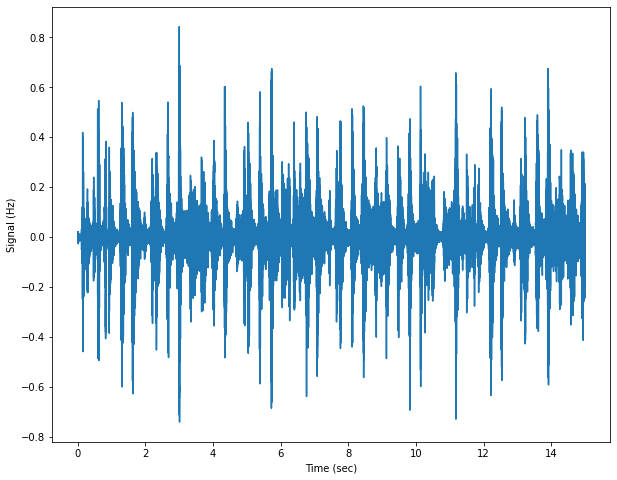

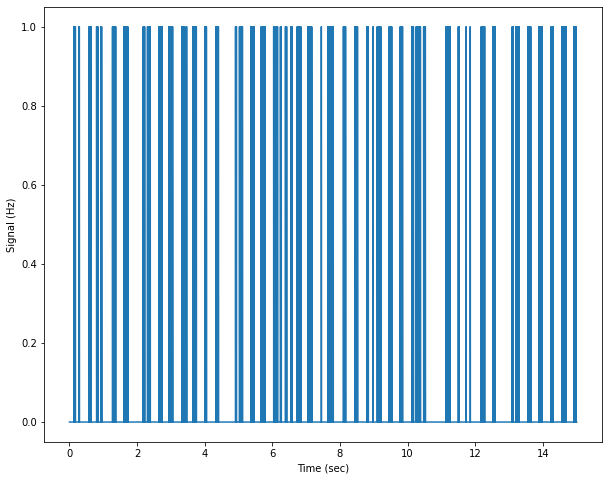

In [ ]:
from matplotlib.pyplot import step, show

def convert_to_sec(audio_slice):
  times = []
  for i in range(len(audio_slice)):
    time = i/22050
    times.append(time)
  return times

def plot_raw(times, audio_slice):
  plt.figure(figsize=(10, 8))
  plt.plot(times,audio_slice)
  plt.xlabel('Time (sec)')
  plt.ylabel('Signal (Hz)')

def make_binary(audio_slice):
  mean = np.mean(audio_slice)
  std_dev = np.std(audio_slice)
  binary_audio = []
  for i in range(len(audio_slice)):
    s = audio_slice[i]
    if s < mean-(2*std_dev):
      binary_audio.append(1)
    else:
      binary_audio.append(0)
  return binary_audio

def plot_binary(times, audio_slice):
  binary_audio = make_binary(audio_slice)
  plt.figure(figsize=(10, 8))
  plt.step(times, binary_audio)
  plt.xlabel('Time (sec)')
  plt.ylabel('Signal (Hz)')
  return binary_audio

times = convert_to_sec(audio_slice)
plot_raw(times, audio_slice)
binary_audio = plot_binary(times, audio_slice)

approx # of total beat moments: 60
aprox # of syllables per bar: 9


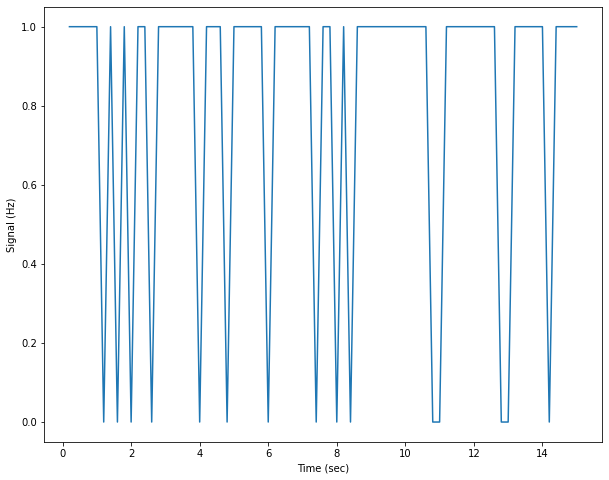

In [ ]:
import math
def count_events(times, binary_audio):
  start,bin = 0, .2
  cut = start+bin
  bin_data = {}
  for i in range(len(binary_audio)):
    t = times[i]
    s = binary_audio[i]
    if t > cut:
      cut = cut + .2
    if cut not in bin_data:
      bin_data[cut] = []
    else:
      bin_data[cut].append(s)
  return bin_data

def approx_syl(bin_dat):
  same, diff = 0,0
  compress = {}
  for t, sigs in bin_dat.items():
    if all(x==sigs[0] for x in sigs):
      compress[t] = sigs[0]
    else:
      compress[t] = 1
  return compress 

def count_beats(compress):
  count = 0
  for k,v in compress.items():
    if v == 1:
      count += 1
  x = list(compress.keys())
  y = list(compress.values())
  return x,y,count

def plot_beats(x,y):
  plt.figure(figsize=(10, 8))
  plt.plot(x,y)
  plt.xlabel('Time (sec)')
  plt.ylabel('Signal (Hz)')
    
bin_dat = count_events(times, binary_audio)
compress = approx_syl(bin_dat)
x,y,beats = count_beats(compress)
plot_beats(x,y)

print("approx # of total beat moments:", beats)
num_syllables=math.ceil(beats/7)
print("aprox # of syllables per bar:", num_syllables)

In [ ]:
def query_openai(prompt):
    response = openai.Completion.create(
        engine="text-davinci-002", 
        temperature=temp,
        prompt=prompt,
        max_tokens=100,
        best_of=11,
        n=10,
        logprobs=1,
    )
    return response

In [ ]:
#@title Parameters
#@markdown Genre and tone have a drop down bar of options to give you ideas, but you can add as many categories as you want by typing more words into the list 

#@markdown temperature range [0-1], 0=less random, 1=more random

rhyme_phrase =  ""#@param {type:"string"}
num_syllables = 8
genre = "country" #@param ["indie", "rock", "jazz", "country", "electronic", "hip-hop", "rap", "folk", "r&b", "pop", "reggae"]
tone = "meloncholy" #@param ["excited", "funny", "wacky", "happy", "meloncholy", "hype", "eclectic", "chill", "soft", "sexy"]
temp =  1#@param {type:"number"}
random_mode = True#@param {type:"boolean"}
if not random_mode:
  prompt = "Write a lyric with {num_syllables} syllables, in the tone {tone} and genre {genre} that rhymes with: '{rhyme_phrase}'".format(num_syllables=num_syllables, tone=tone, genre=genre, rhyme_phrase=rhyme_phrase)
else:
  prompt = "Write a lyric with {num_syllables} syllables, in the tone {tone} and genre {genre} ".format(num_syllables=num_syllables, tone=tone, genre=genre)

In [ ]:
response = query_openai(prompt)
for result in response.choices:
    print(prompt + " " + result.text)
    print("\n \n")

Write a lyric with 8 syllables, in the tone meloncholy and genre country  

I'm so tired of being lonely
I'm so tired of being blue
I'm so tired of everyone leaving
I'm just so tired of being me

 

Write a lyric with 8 syllables, in the tone meloncholy and genre country  

I'm so tired of being lonely
I'm so tired of being sad
I'm so tired of being single
I'm so tired of being bad

 

Write a lyric with 8 syllables, in the tone meloncholy and genre country  

I'm so lonely
I'm so sad
I'm so blue
I'm so mad

 

Write a lyric with 8 syllables, in the tone meloncholy and genre country  

I'm missing you 
I'm feeling blue 
I'm losing sleep 
I can't eat 
I cry all day
I want you back 
I'm going insane 
Please come home

 

Write a lyric with 8 syllables, in the tone meloncholy and genre country  

I'm so tired of being sad 
I'm so tired of feeling mad 
I'm so tired of being alone 
I'm so tired of feeling like I've got nowhere to go

 

Write a lyric with 8 syllables, in the tone meloncholy